<details>
<summary><b>Overview</b></summary>

## CIFAR-10 Image Analysis using CLIP Embeddings

This project demonstrates a workflow for analyzing the CIFAR-10 dataset using pretrained OpenAI CLIP embeddings.  
The main goals are to extract meaningful image representations, compute similarities between classes, and evaluate distributional differences using FID.

---

## Workflow Steps

### 1. Load and Prepare Data
- Load CIFAR-10 dataset using TensorFlow Keras.
- Flatten labels for easier indexing and processing.

### 2. Image Resizing
- CIFAR-10 images are originally 32x32 pixels.
- Resized to 224x224 pixels using bilinear interpolation to match CLIP input requirements.
- Batch processing used to prevent memory overload in Google Colab.

### 3. CLIP Model Setup
- Load pretrained OpenAI CLIP model and processor using Hugging Face Transformers.
- The processor handles image preprocessing and tokenization.

### 4. Class Label Mapping
- Map numeric CIFAR-10 labels to human-readable class names for easier interpretation.
- Create an array of class names corresponding to the training dataset.

### 5. Generate Image Embeddings
- Process images in batches and extract CLIP image features.
- Concatenate batch embeddings into a single tensor.
- Save embeddings for later use.

### 6. Embedding Normalization
- Apply L2 normalization to each embedding vector.
- Normalized embeddings facilitate cosine similarity computations.

### 7. Class-Level Mean Embeddings & Cosine Similarity
- Compute mean embedding per class.
- Normalize mean embeddings to unit length.
- Compute and visualize cosine similarity matrix between CIFAR-10 classes.

### 8. FID Computation Between Classes
- Compute per-class statistics (mean and covariance) for embeddings.
- Use Fréchet distance to compute FID between every pair of classes.
- Visualize the FID matrix as a heatmap to understand distributional differences between classes.

---

</details>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
from PIL import Image
from tqdm import tqdm

import tensorflow as tf

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
# Resizing CIFAR images from 32x32 to 224x224

def resize_cifar(img_array, target_size=224):
    pil_img = Image.fromarray(img_array)
    pil_img = pil_img.resize((target_size, target_size), Image.BILINEAR) # Bilinear interpolation
    return pil_img

# Had to do it batchwise or else google colab would crash due to memory overload
def resize_cifar_batch(x, target_size=224, batch_size=500):
    resized = []
    for i in tqdm(range(0, len(x), batch_size)):
        batch = x[i:i+batch_size]
        batch_resized = [resize_cifar(img, target_size) for img in batch]
        resized.extend(batch_resized)
    return resized

images = resize_cifar_batch(x_train, target_size=224, batch_size=500)

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [ ]:
from transformers import CLIPProcessor, TFCLIPModel

# loads the OpenAI CLIP model and its corresponding processor

model_name="openai/clip-vit-base-patch32"
model = TFCLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
} # maps numeric CIFAR-10 labels to their corresponding class names

class_names = np.array([cifar10_classes[label] for label in y_train]) # Convert numeric labels in y_train to class names using the dictionary

In [ ]:
# generates CLIP image embeddings

all_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(images), batch_size)):
    batch = images[i:i+batch_size]
    inputs = processor(images=batch, return_tensors="tf", padding=True)
    emb = model.get_image_features(**inputs)
    all_embeddings.append(emb)

image_embeddings = tf.concat(all_embeddings, axis=0)
np.save("embeddings.npy", image_embeddings)

print("Embeddings shape:", image_embeddings.shape)

100%|██████████| 782/782 [16:12<00:00,  1.24s/it]


Embeddings shape: (50000, 512)


In [ ]:
# L2 Normalization of embeddings

norms = np.linalg.norm(image_embeddings, axis=1, keepdims=True)
norms[norms == 0] = 1.0
image_embeddings_norm = image_embeddings / norms
np.save("norm_emb.npy", image_embeddings_norm)

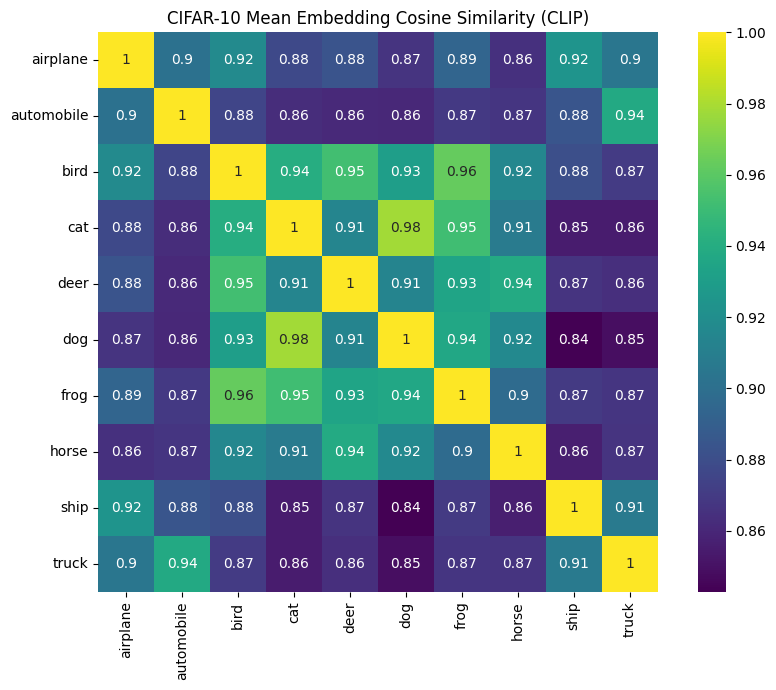

In [9]:
import seaborn as sns

classes = sorted(list(set(class_names)))
class_mean_emb = {}

image_embeddings_norm = np.array(image_embeddings_norm)


for cls in classes:
    idx = np.where(class_names == cls)[0]
    mean_emb = np.mean(image_embeddings_norm[idx], axis=0)  # mean of normalized vectors
    # Normalize the class mean for cosine computations
    mean_emb = mean_emb / (np.linalg.norm(mean_emb) + 1e-12)
    class_mean_emb[cls] = mean_emb

# Cosine similarity matrix (mean-based)
num_classes = len(classes)
cosine_sim_matrix = np.zeros((num_classes, num_classes))
for i, c1 in enumerate(classes):
    for j, c2 in enumerate(classes):
        cosine_sim_matrix[i, j] = float(np.dot(class_mean_emb[c1], class_mean_emb[c2]))

# Visualize cosine similarity
plt.figure(figsize=(9, 7))
sns.heatmap(cosine_sim_matrix, xticklabels=classes, yticklabels=classes,
            annot=True, cmap="viridis", square=True)
plt.title("CIFAR-10 Mean Embedding Cosine Similarity (CLIP)")
plt.tight_layout()
plt.show()

In [ ]:
from scipy import linalg

def compute_statistics(embeddings):
    """
    embeddings: numpy array (N, D)
    returns (mu, sigma)
    """
    mu = np.mean(embeddings, axis=0)
    sigma = np.cov(embeddings, rowvar=False)
    return mu, sigma

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute Fréchet distance between two multivariate Gaussians.
    """
    diff = mu1 - mu2
    # Add eps to diagonals to improve numerical stability
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        # Add small epsilon to diagonal and retry
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2.0 * tr_covmean
    return float(np.real(fid))

In [ ]:
image_embeddings = np.load("embeddings.npy")
image_embeddings_norm = np.load("norm_emb.npy")

In [ ]:
# computes the FID matrix between CIFAR-10 classes

class_mu_sigma = {}

image_embeddings = np.array(image_embeddings)

for cls in classes:
    idx = np.where(class_names == cls)[0]
    emb = image_embeddings[idx]
    mu, sigma = compute_statistics(emb)
    class_mu_sigma[cls] = (mu, sigma)

fid_matrix = np.zeros((num_classes, num_classes))
for i, c1 in enumerate(classes):
    mu1, s1 = class_mu_sigma[c1]
    for j, c2 in enumerate(classes):
        mu2, s2 = class_mu_sigma[c2]
        fid_matrix[i, j] = frechet_distance(mu1, s1, mu2, s2)



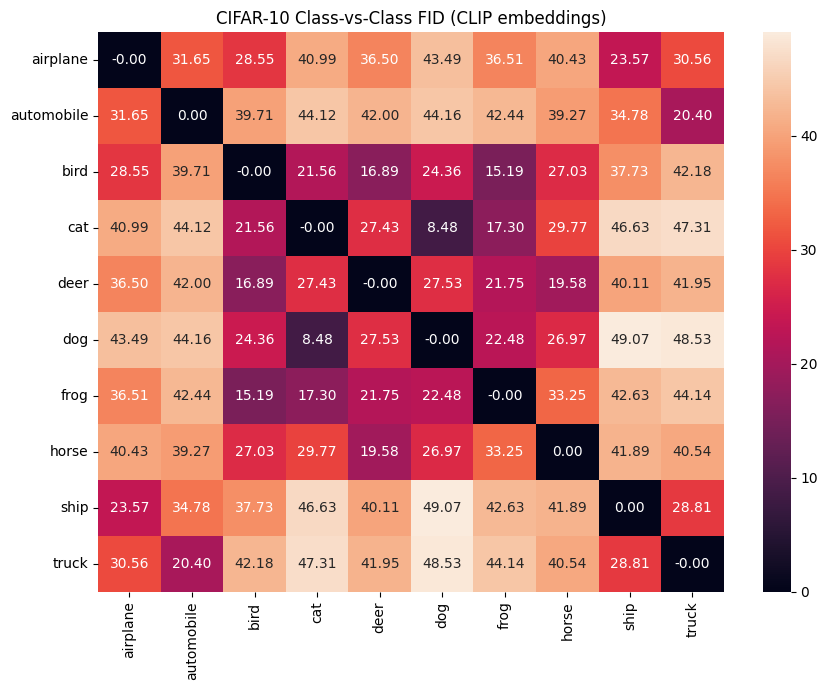

In [12]:
plt.figure(figsize=(9, 7))
sns.heatmap(fid_matrix, xticklabels=classes, yticklabels=classes,
            annot=True, fmt=".2f")
plt.title("CIFAR-10 Class-vs-Class FID (CLIP embeddings)")
plt.tight_layout()
plt.show()